In [1]:
import scipy
import time
from scipy import sparse
from sklearn.preprocessing import normalize
import networkx as nx
import numpy as np
from tqdm import trange
from collections import deque
import matplotlib.pyplot as plt
from kawai import draw_kamada_kawai
import json

In [2]:
matrix = scipy.sparse.load_npz('wiki_sparse.npz')

In [3]:
infile = open('page2id.txt', encoding='utf8')
data = infile.readlines()[0][1:-1].split(',')

In [4]:
page2id = dict()

In [5]:
for pair in data:
    page, idx = pair.split(': ')
    page2id[int(idx)] = page[1:-1].split('/')[-1]

In [6]:
all_cols = np.arange(matrix.shape[1])
keep = np.where(np.logical_not(np.in1d(all_cols, 163)))[0]
matrix = matrix[:, keep]
matrix = matrix[keep, :]
matrix.shape

(1934503, 1934503)

In [7]:
def pagerank(k=300, alpha=0.85):
    n = matrix.shape[0]
    P = normalize(matrix, norm='l1', axis=1)
    x = np.ones(n) / n
    A = P.T
   
    for _ in trange(k):
        new = alpha * A.dot(x) + (1 - alpha) * np.ones(n) / n
        x = new / np.sum(new)
        eps = np.linalg.norm(alpha * A.dot(x) + (1 - alpha) * np.ones(n) / n - x)
        if eps < 1e-5:
            break
    print('error:', eps)
    return x

In [8]:
def degree_centrality():
    rank = matrix.sum(axis=0)
    return rank / rank.sum()

In [9]:
def eigenvector(k=300, eps=1e-5):
    n = matrix.shape[0]
    x = np.ones(n) / n
    for _ in trange(k):
        x = matrix.dot(x)
        x = x / np.linalg.norm(x)
        eigval = x.dot(matrix.dot(x))
        res = matrix.dot(x) - eigval * x
        if np.linalg.norm(res) < eps:
            break
    print('error:', np.linalg.norm(res))
    return x

In [10]:
def hits(k=300):
    n = matrix.shape[0]
    a = np.ones(n) / n
    h = np.ones(n) / n
    
    A = normalize(matrix, norm='l1', axis=1)
    for _ in range(k):
        a = A.T.dot(A.dot(a))
        h = A.dot(A.T.dot(h))
        
        a = a / np.linalg.norm(a)
        h = h / np.linalg.norm(h)
        
        eps = np.linalg.norm(A.T.dot(A.dot(a)) - a)
        if eps < 1e-5:
            break
    print('error:', eps)
    return a, h

In [11]:
def visualizer(vector, top=1, deep=2, neighbor_count=4, label=False):
    n = vector.shape[0]
    graph = nx.DiGraph()
    
    # Select only top ranked nodes
    top_pages = np.argsort(-vector)[:top]
    
    # Initializing for BFS
    vistied = np.zeros(n, dtype=bool)
    vistied[top_pages] = True
    distance = np.zeros(n)
    pages = deque(top_pages)
    
    while len(pages) > 0:
        page = pages.popleft()
        vistied[page] = True
        
        # indexes of top neighbors
        neighbors = sparse.find(matrix[page] > 0)[1]
        indexes = np.argsort(-vector[neighbors])[:neighbor_count]
        neighbors = neighbors[indexes]
        
        # Visiting top neighbors which are not visited
        for neighbor in neighbors:
            graph.add_edge(page, neighbor)
            if not vistied[neighbor] and distance[page] < deep:
                pages.append(neighbor)
                distance[neighbor] = distance[page] + 1

    # Plot
    plt.figure(1, figsize = (20, 20))
    nodes = list(graph.nodes())
    rank = vector / max(vector)
    colors = [rank[node] * 6000 for node in nodes]
    sizes = [rank[node] * 6000 for node in nodes]
    
    names = dict([(node, node) for node in nodes])
    if label:
        names = dict([(node, page2id[node]) for node in nodes])
        
    draw_kamada_kawai(
        graph, 
        node_size = sizes, 
        node_color = colors, 
        width = 0.1,
        labels = names,
    )
    plt.show()

In [12]:
pgrk = pagerank()

100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [03:32<00:00,  1.41it/s]


error: 0.0006080870755175782


In [13]:
eig = eigenvector()

 18%|██████████████▌                                                                  | 54/300 [00:44<03:20,  1.22it/s]

error: 7.396558320604687e-06


In [14]:
a, h = hits(k=50)

error: 396.4707292051969


C:\Users\user\Documents\wikipedia\kawai.py:572: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
C:\Users\user\Documents\wikipedia\kawai.py:669: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cb.iterable(node_size):  # many node sizes


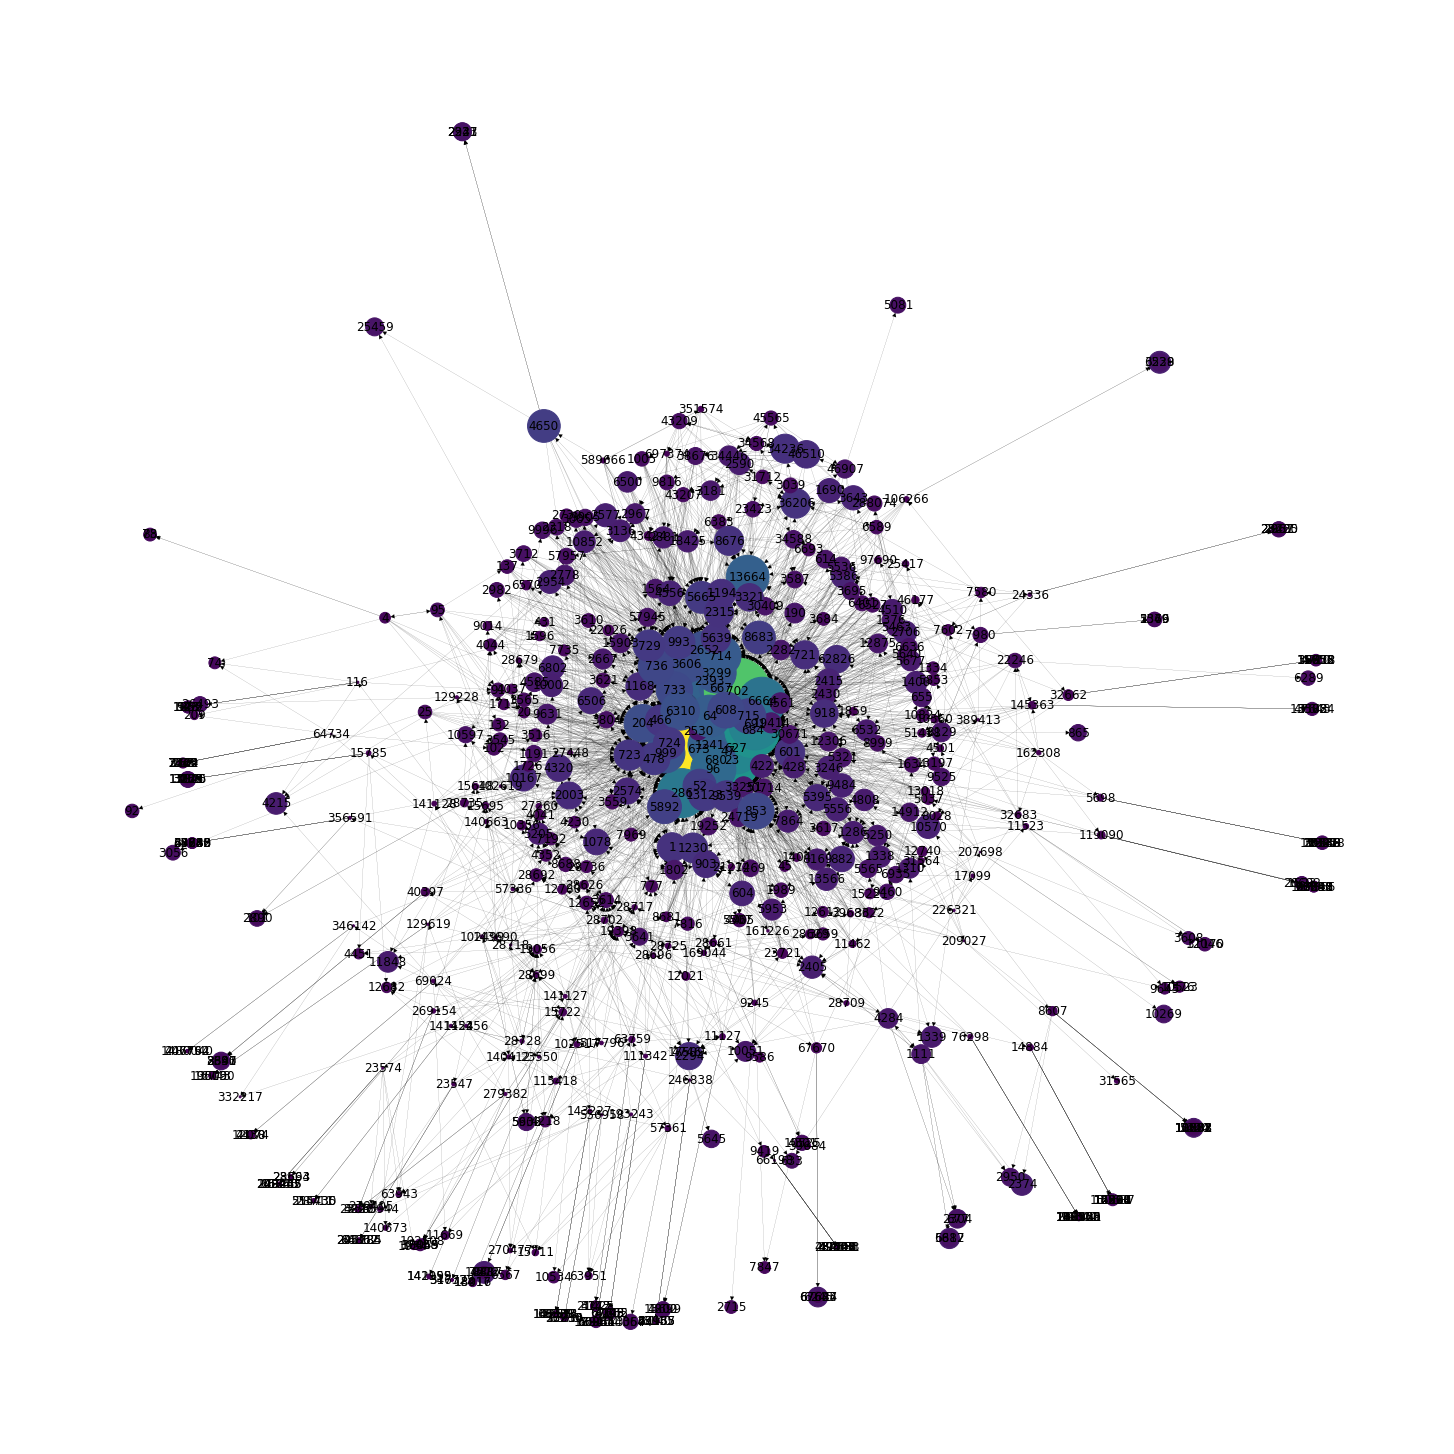

In [15]:
visualizer(pgrk, top=20, deep=5, neighbor_count=10, label=False)

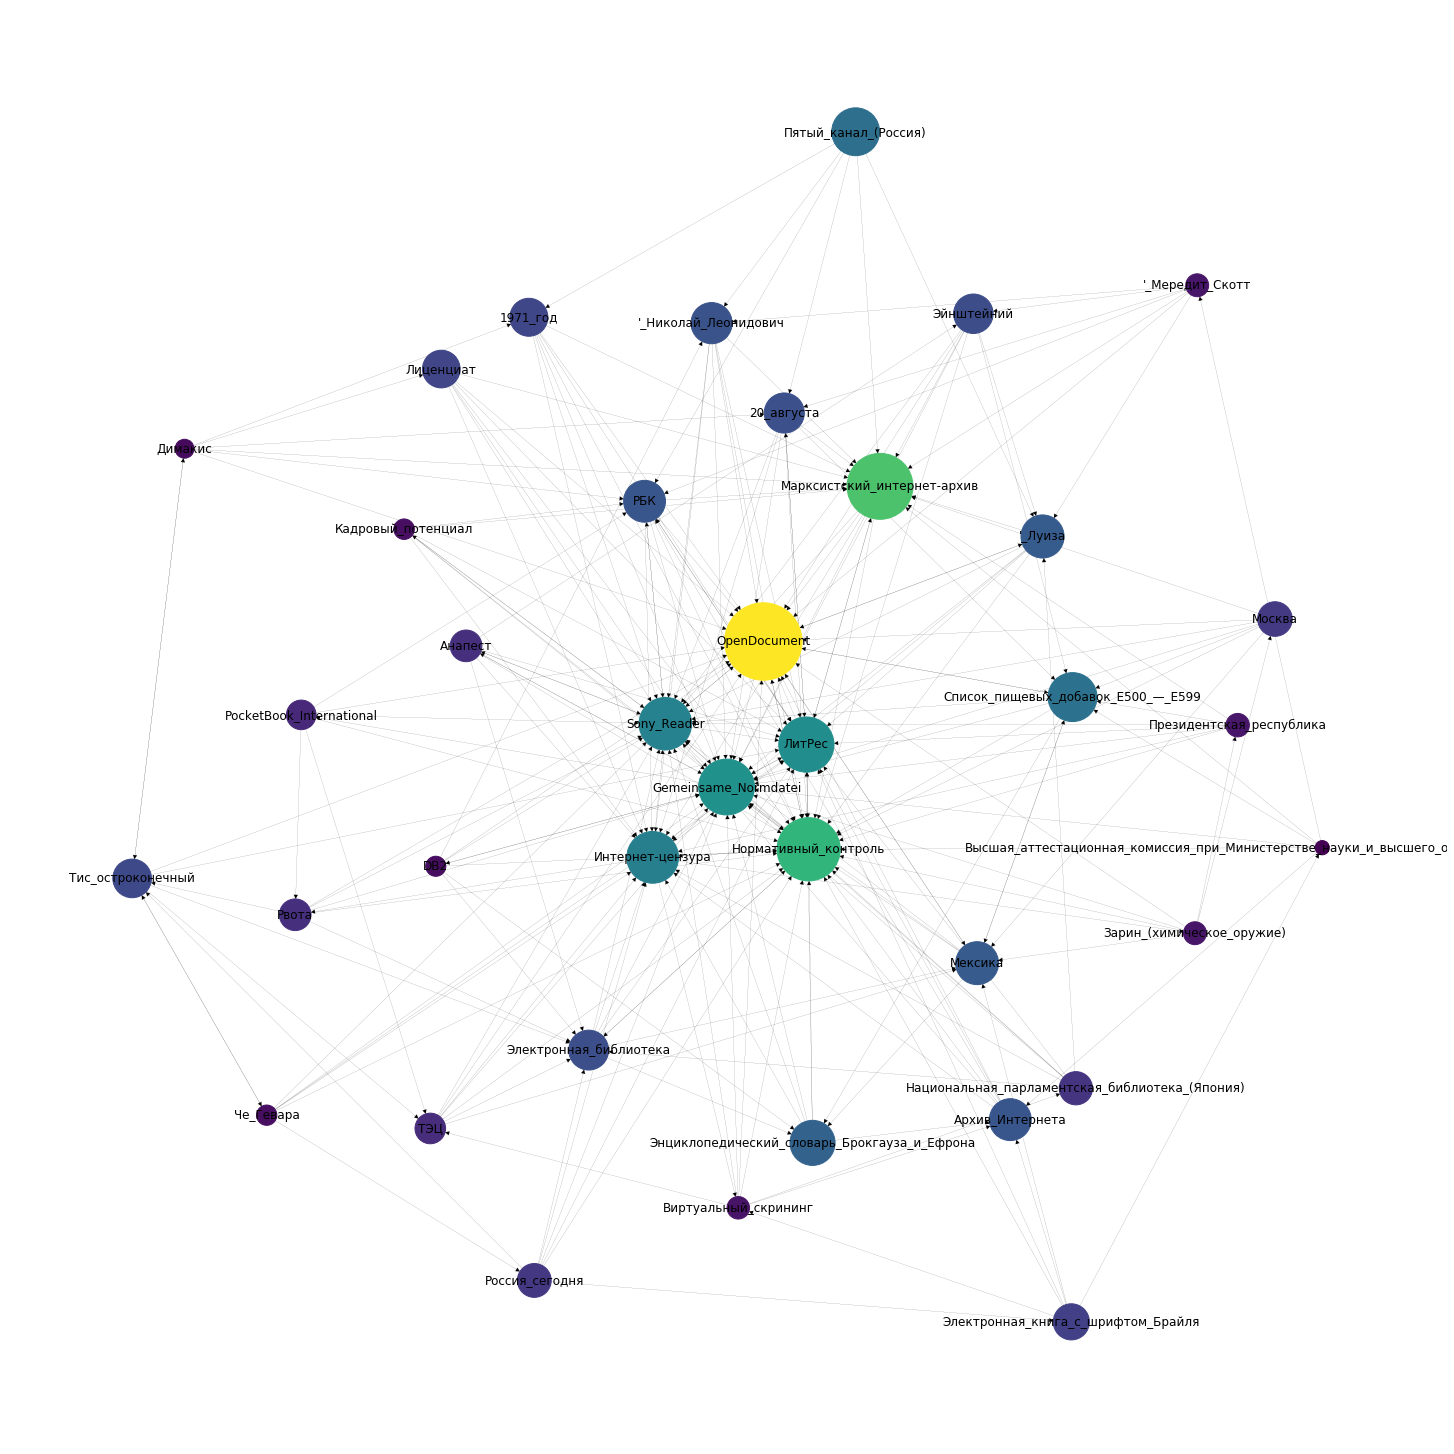

In [16]:
visualizer(pgrk, top=10, deep=10, neighbor_count=7, label=True)

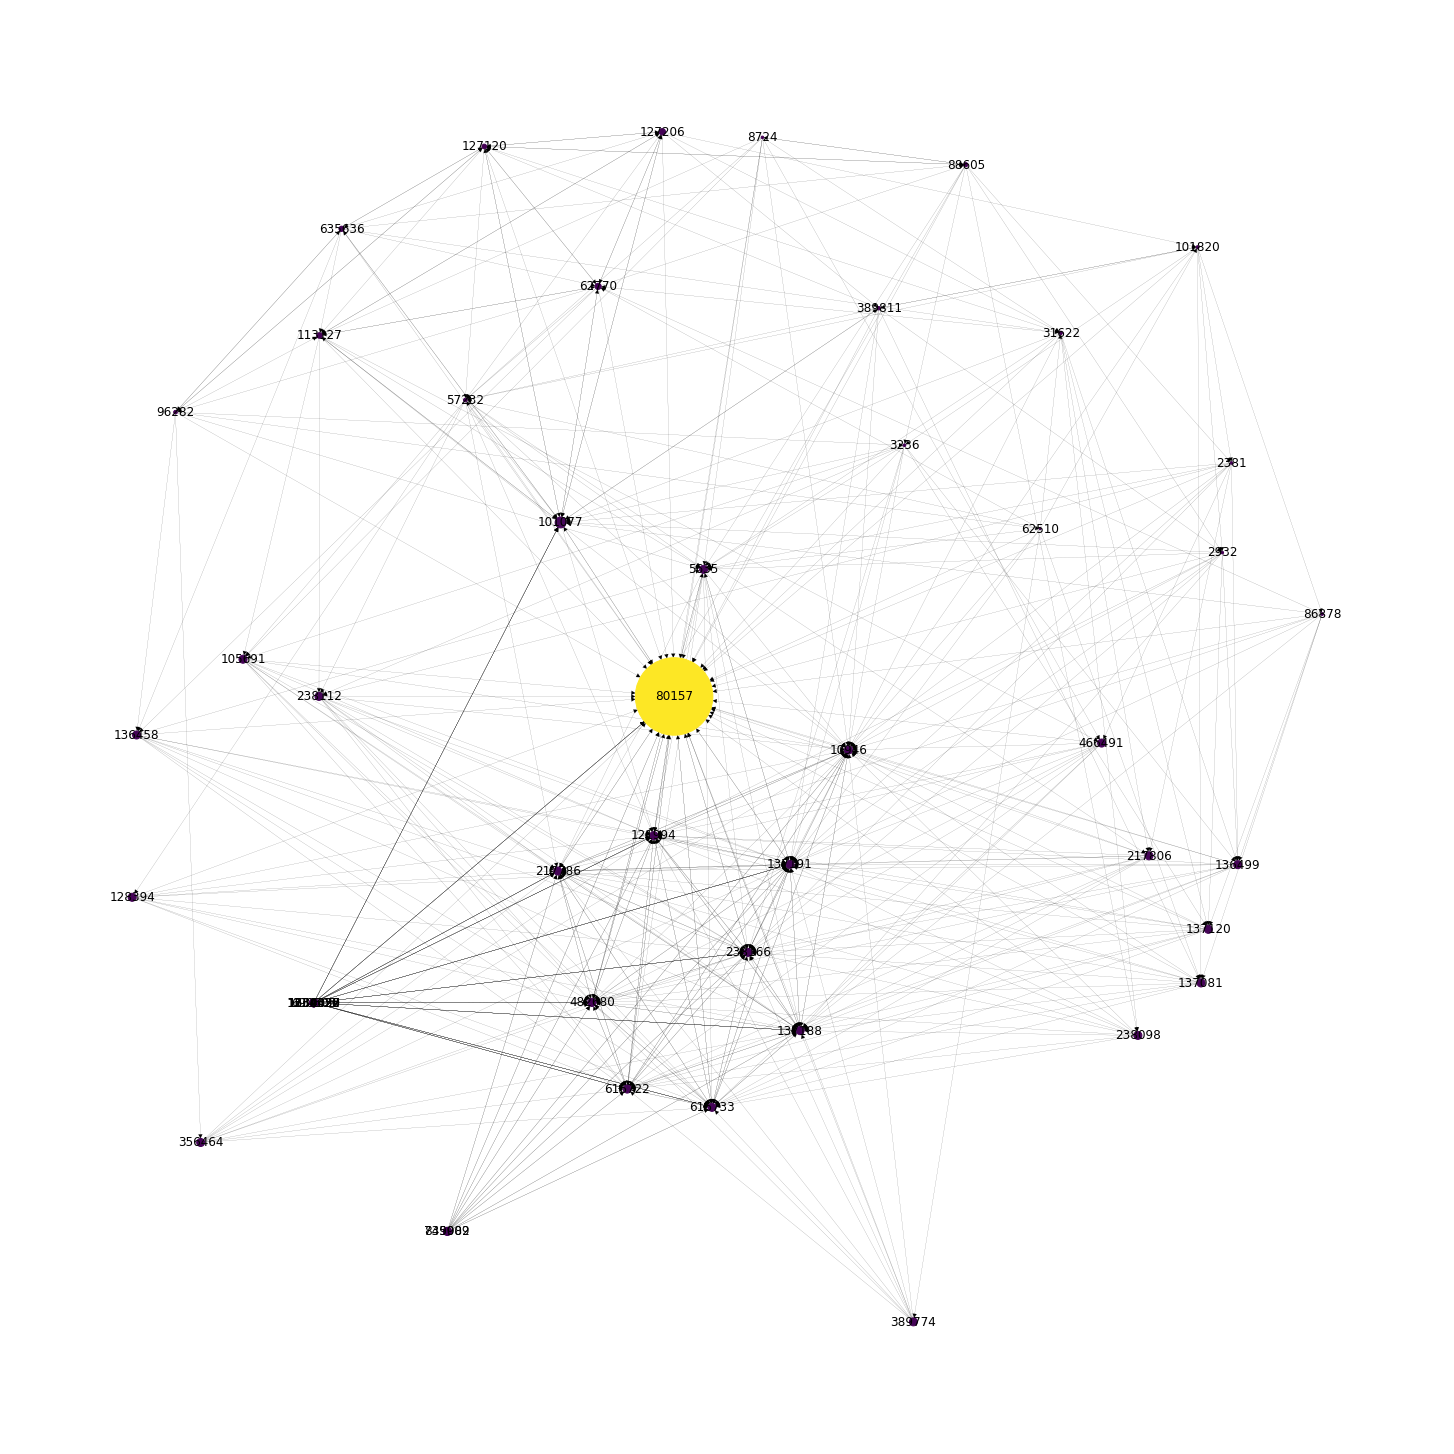

In [17]:
visualizer(eig, top=20, deep=5, neighbor_count=10, label=False)

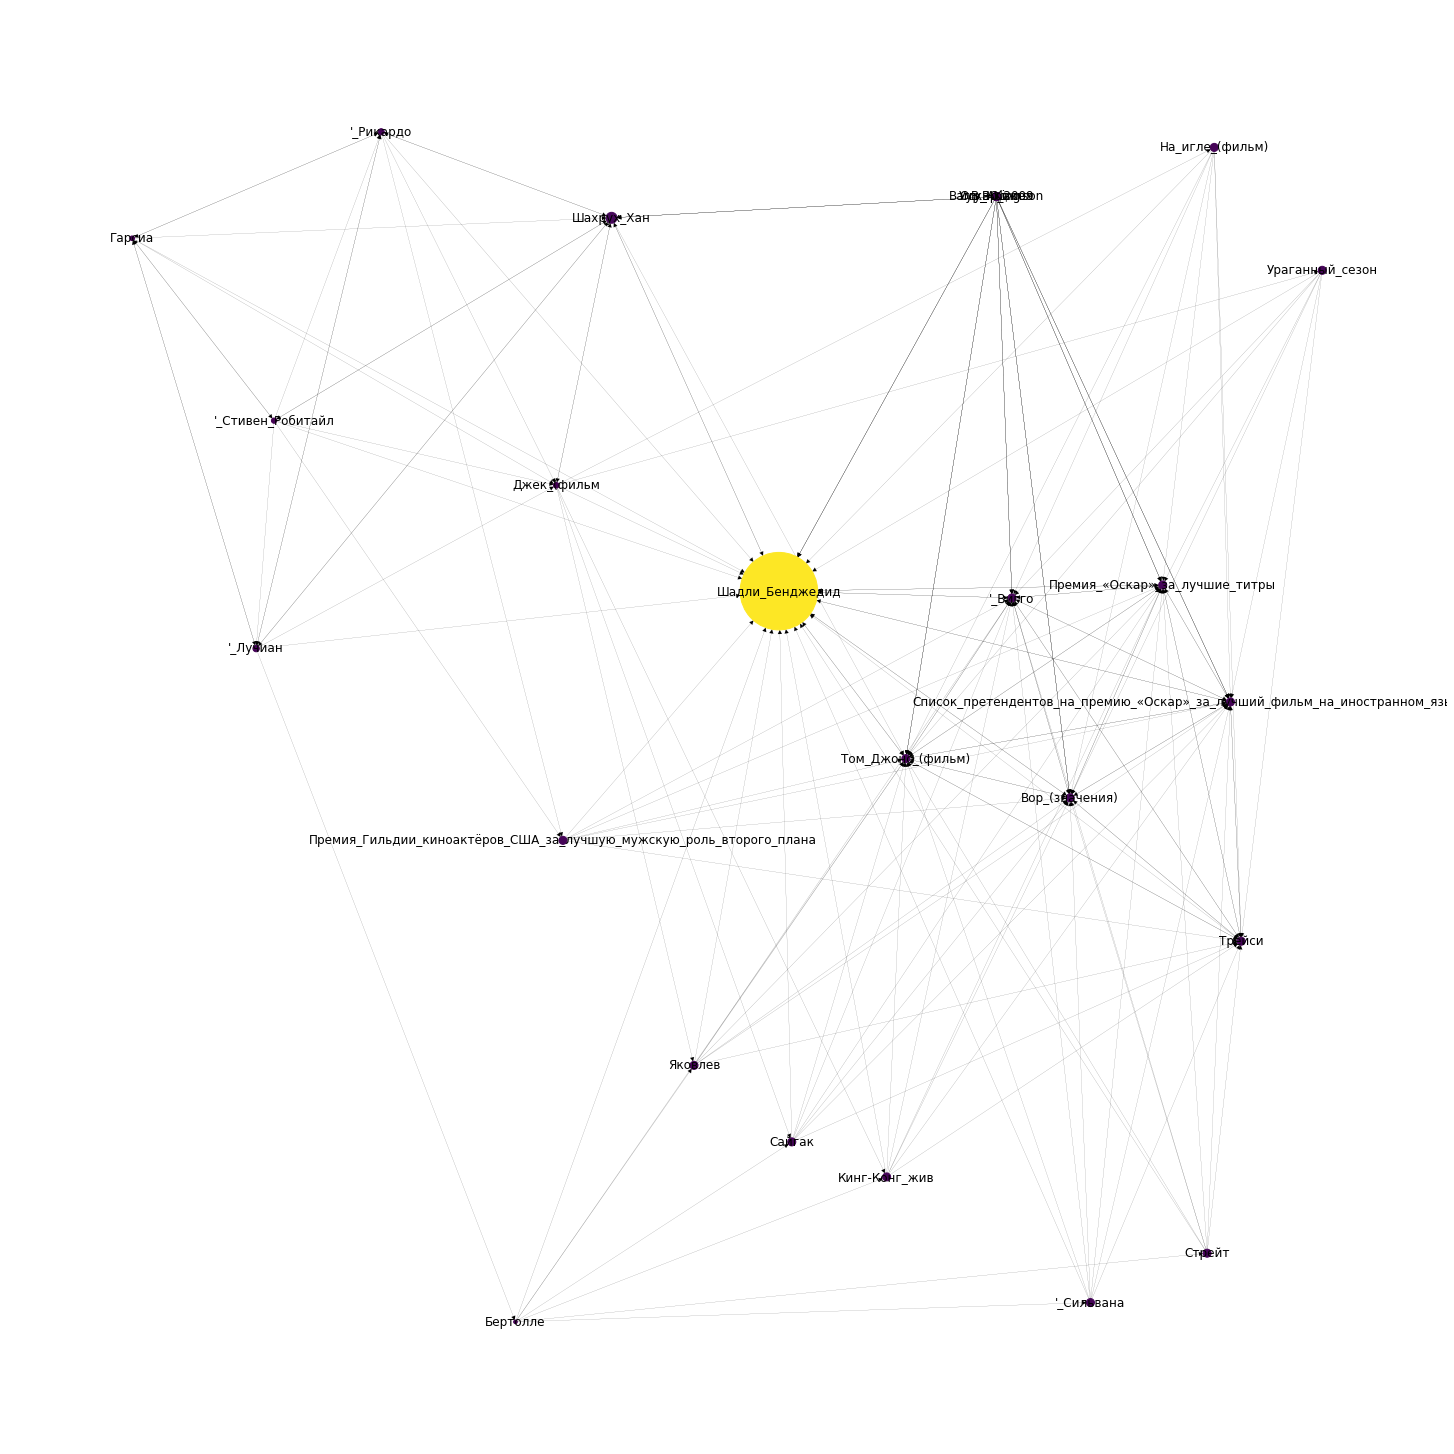

In [18]:
visualizer(eig, top=10, deep=10, neighbor_count=7, label=True)

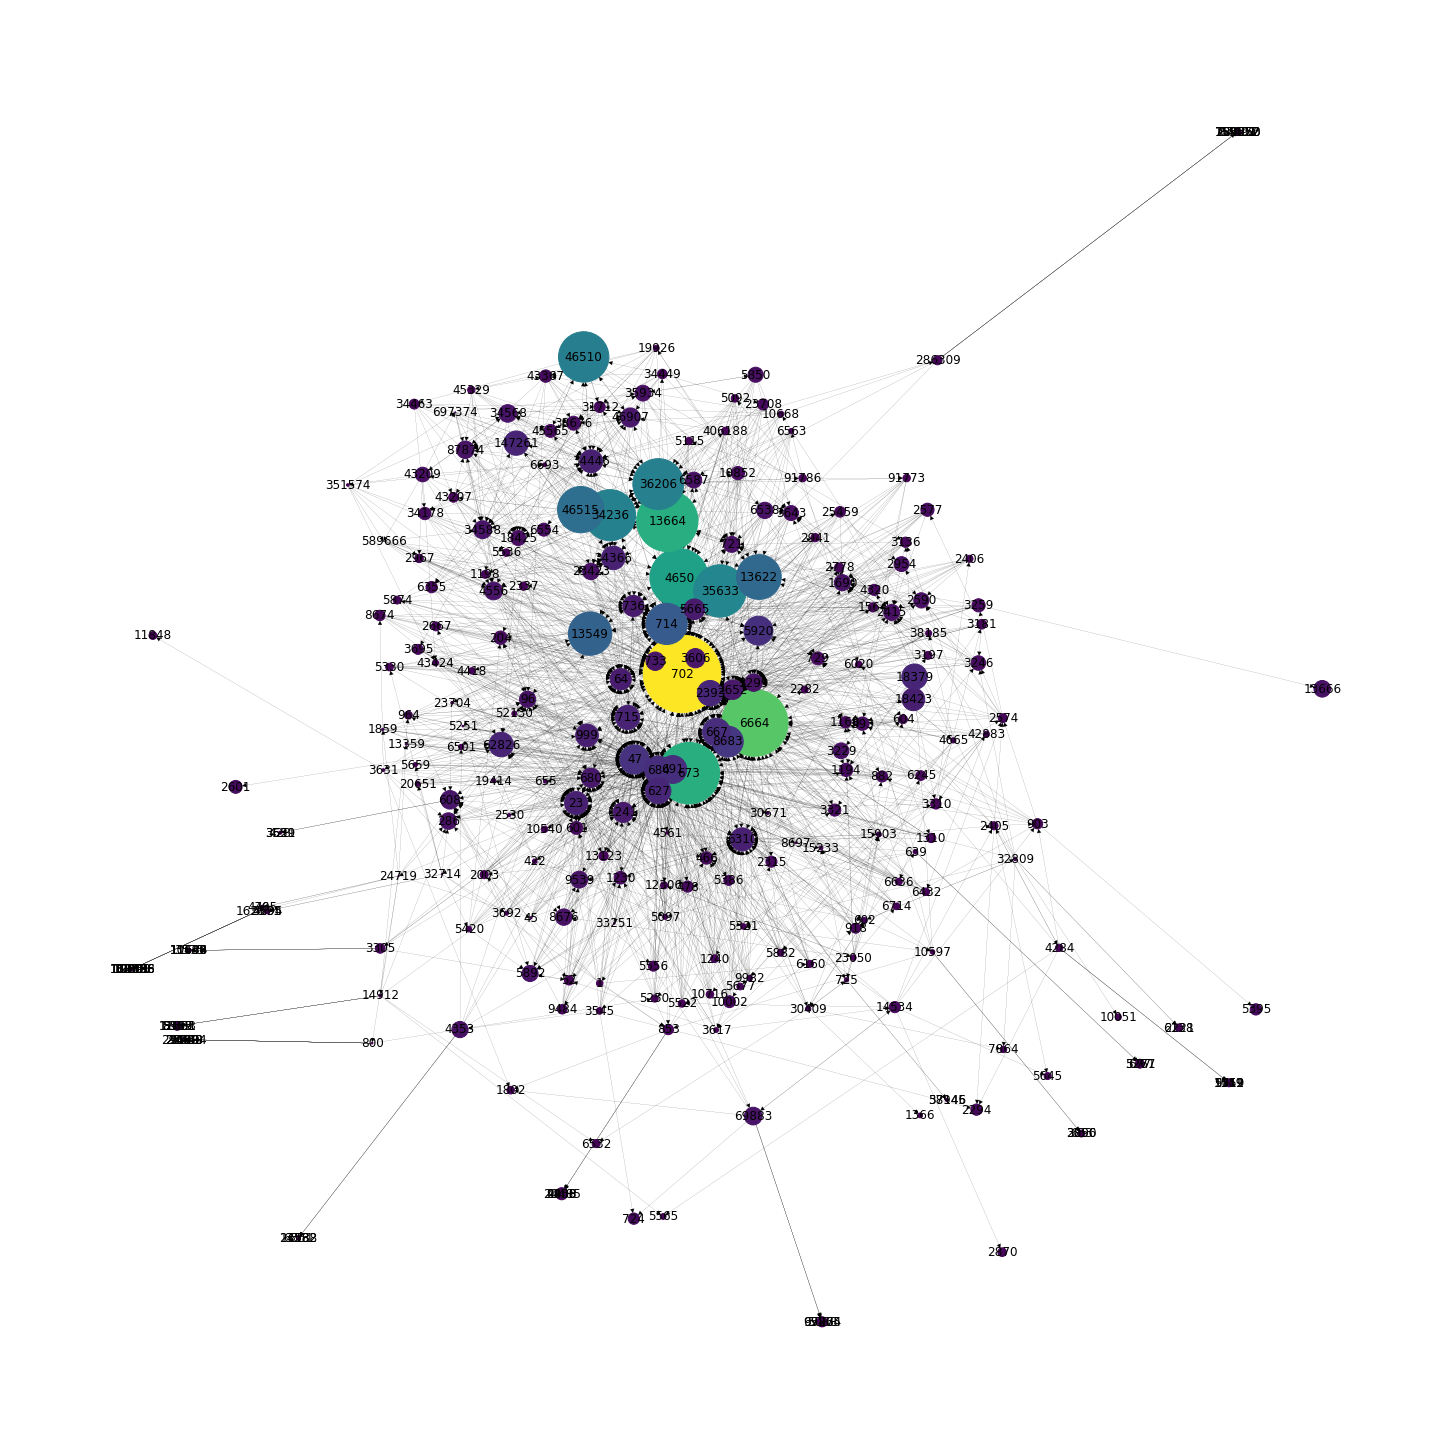

In [19]:
visualizer(a, top=20, deep=5, neighbor_count=10, label=False)

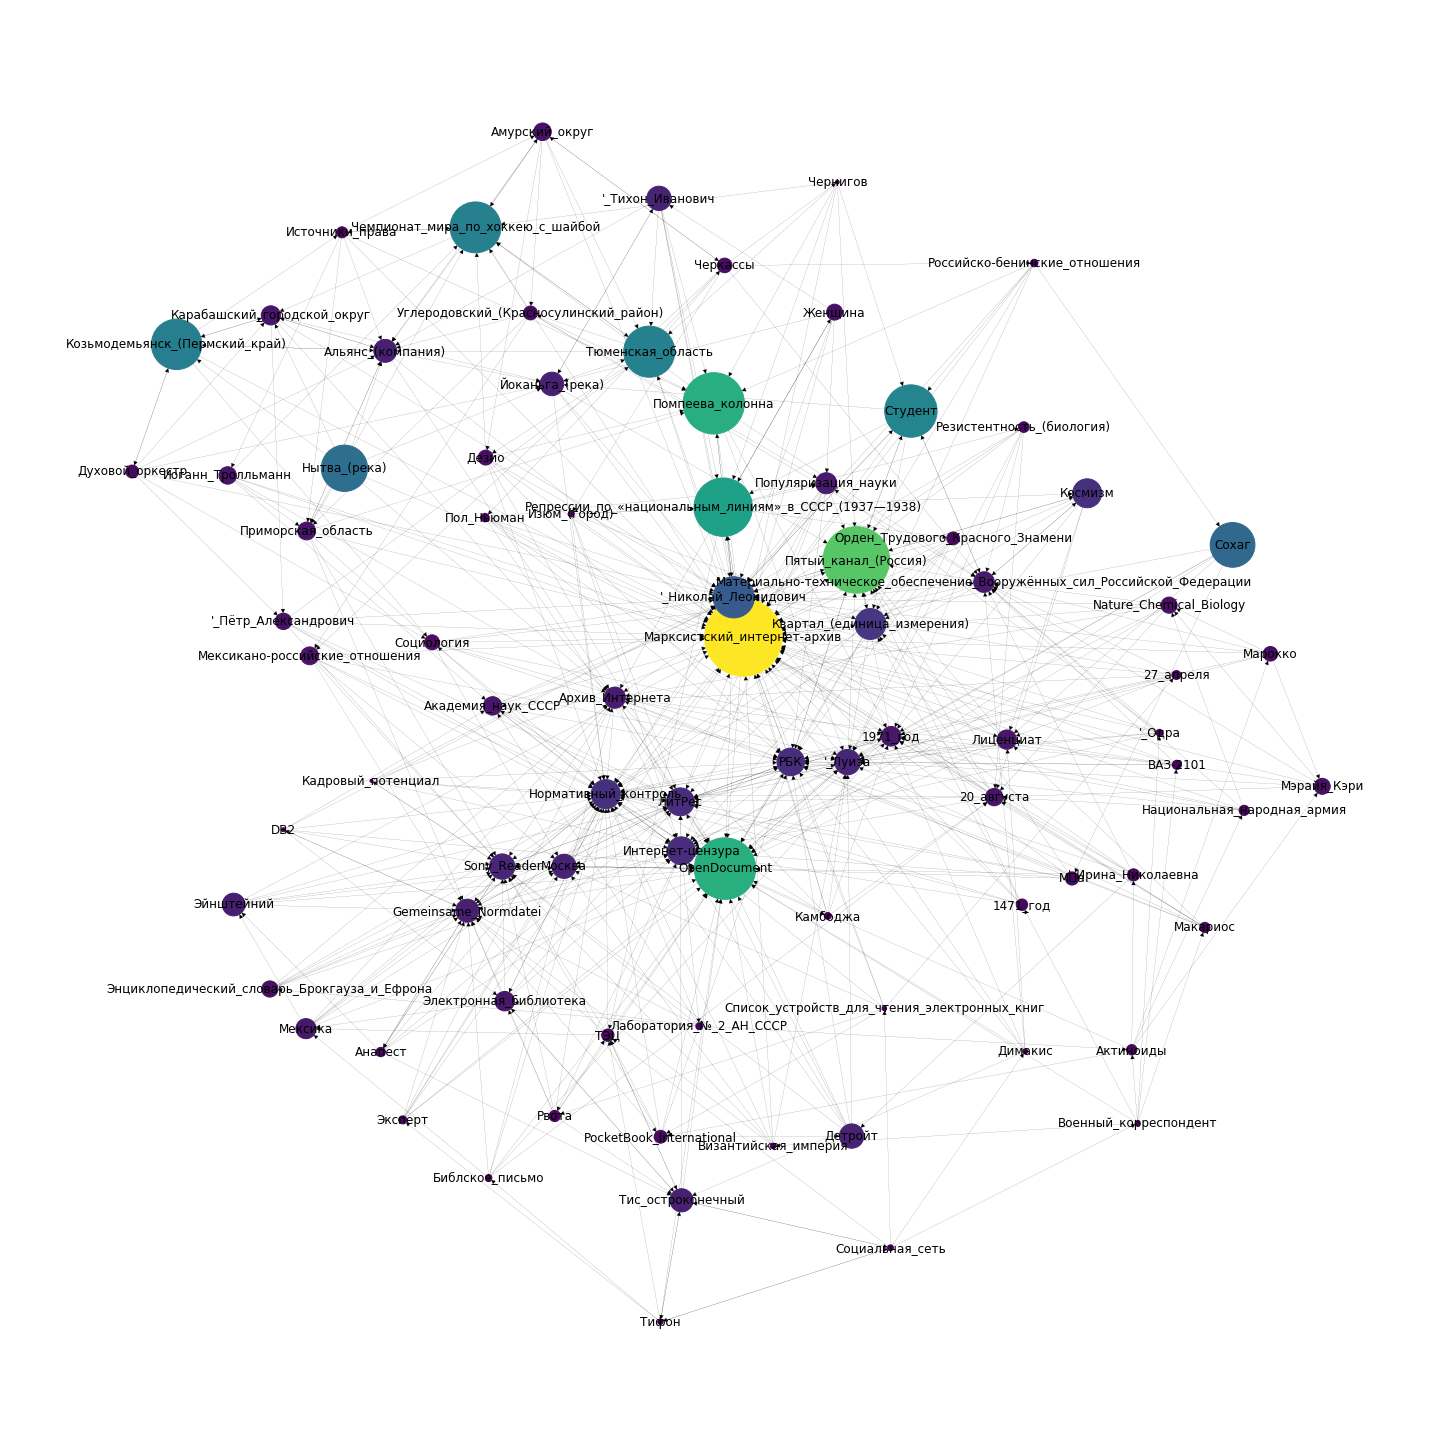

In [20]:
visualizer(a, top=10, deep=10, neighbor_count=7, label=True)

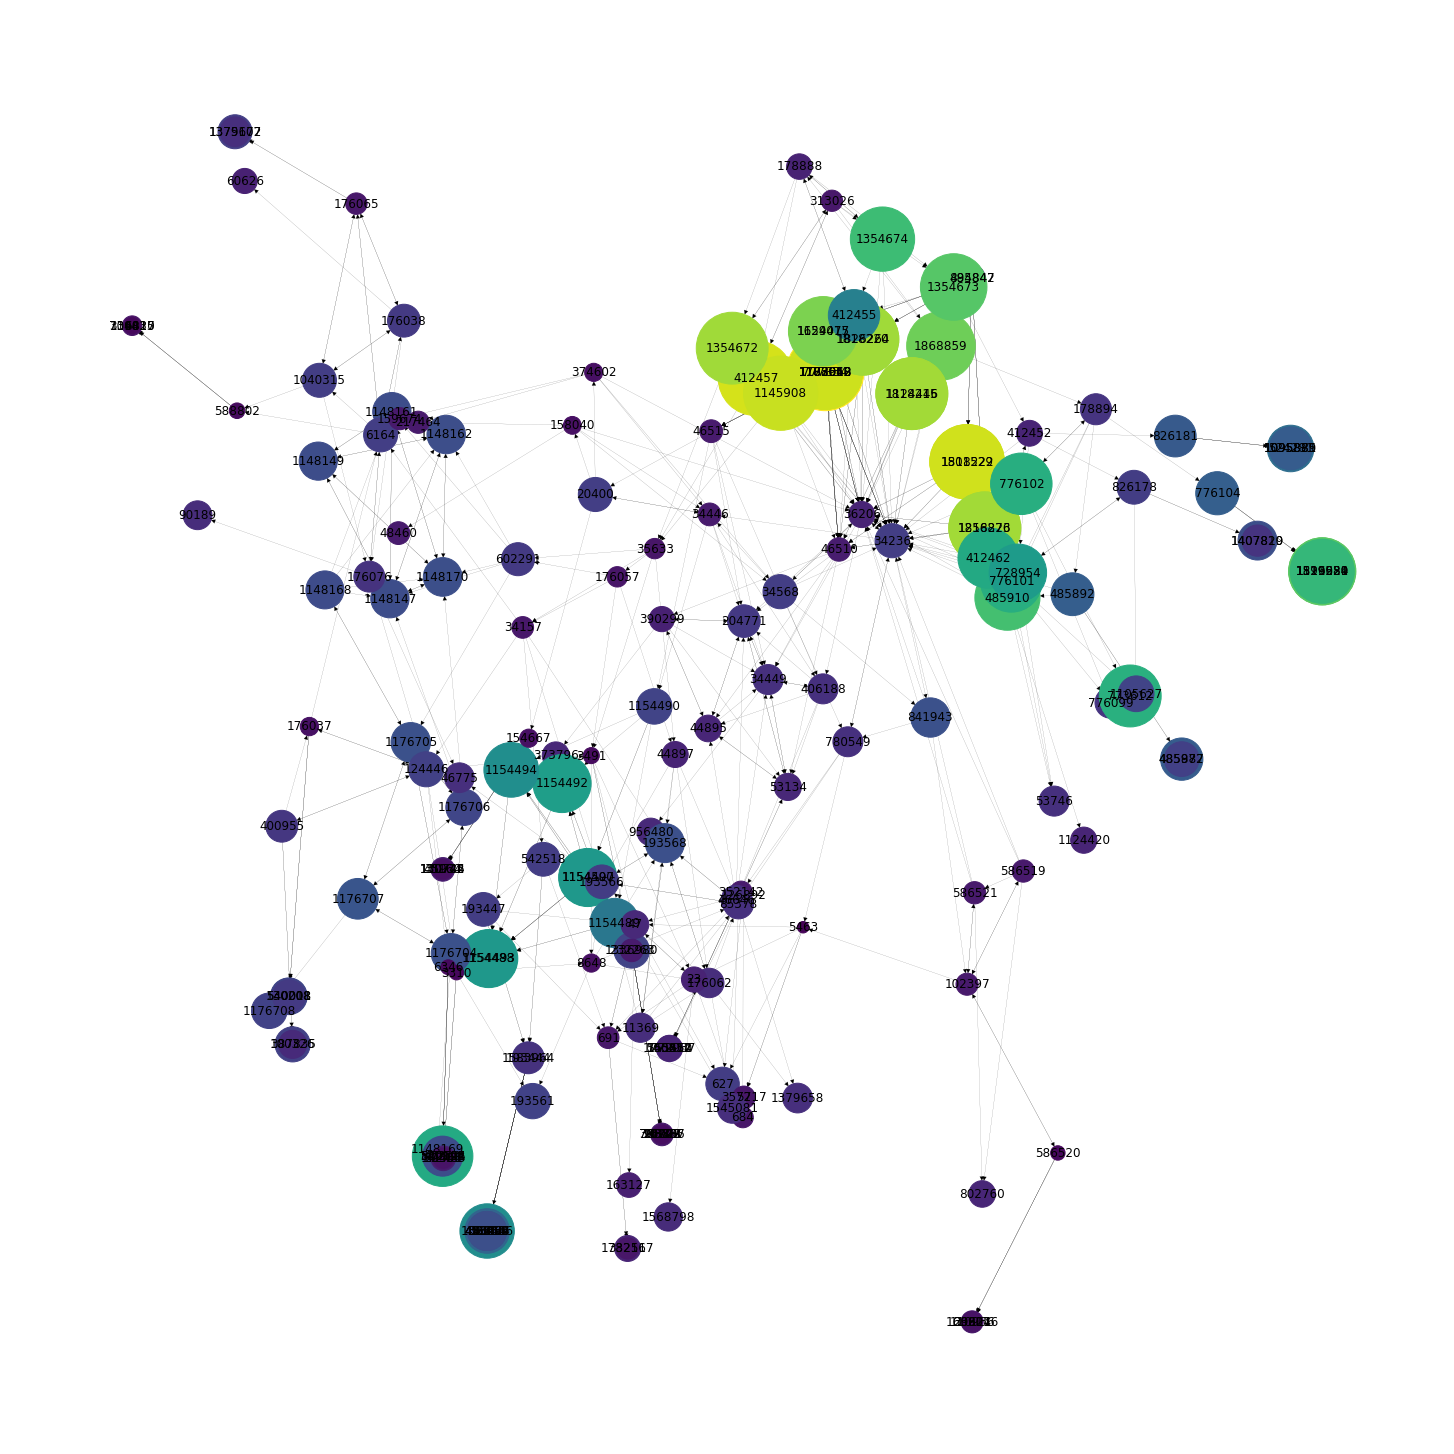

In [29]:
visualizer(h, top=10, deep=4, neighbor_count=5, label=False)

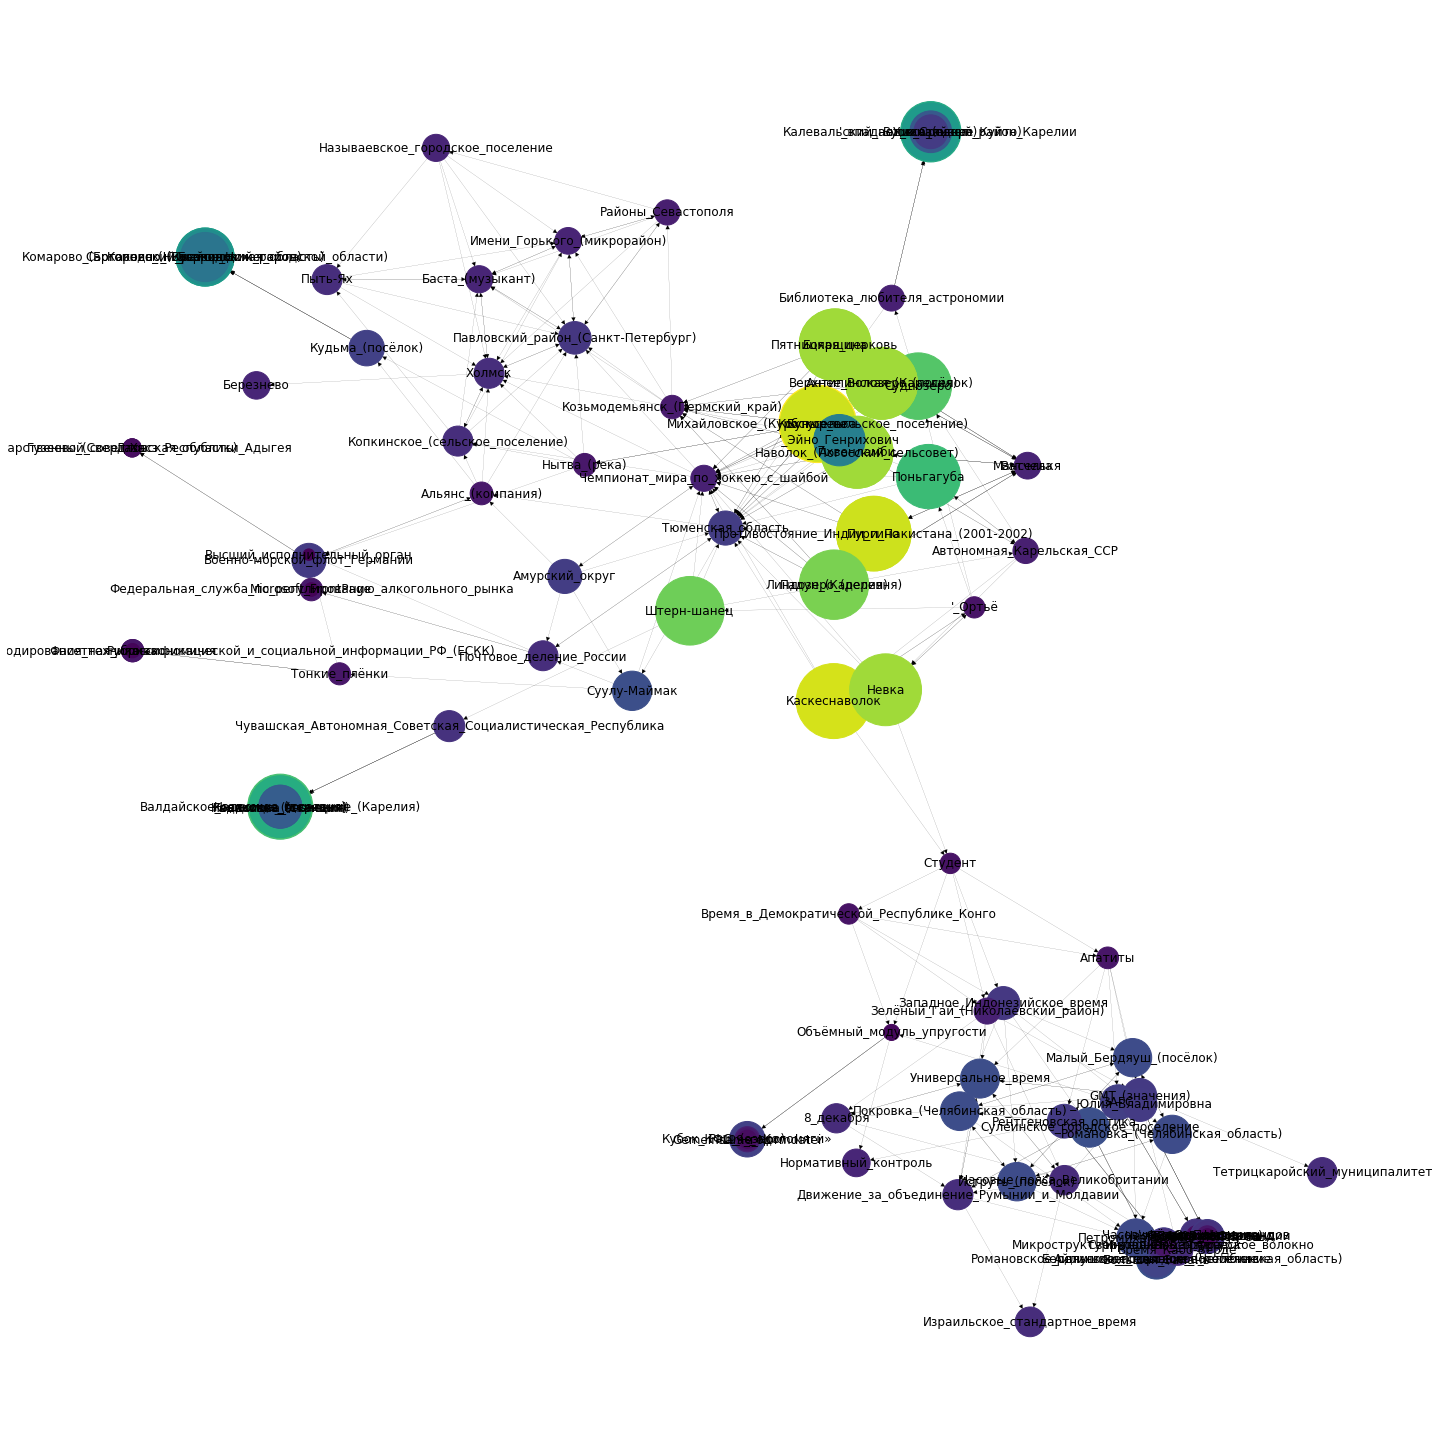

In [43]:
visualizer(h, top=6, deep=3, neighbor_count=5, label=True)